In [1]:
from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
import random
import numpy as np

In [2]:
def unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model
 

In [3]:
# image_directory = '/home/dsp_tameo/tamiyo-p3/models/u-net/data/train/'
# mask_directory = '/home/dsp_tameo/tamiyo-p3/models/u-net/data/masks/'
image_directory = './data/train/'
mask_directory = './data/masks/'

In [4]:
SIZE = 256
image_dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
mask_dataset = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.


In [5]:
images = os.listdir(image_directory)

In [6]:
for i, image_name in enumerate(images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'tif'):
#         print(image_directory+image_name)
        image = cv2.imread(image_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))

In [7]:
masks = os.listdir(mask_directory)
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'tif'):
        image = cv2.imread(mask_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))

In [8]:
#Normalize images
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)


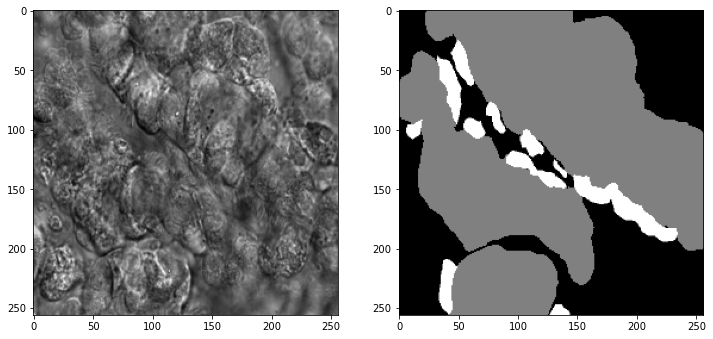

In [10]:
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

In [11]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

In [12]:
model = unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        dropout[0][0]                    
______________________________________________________________________________________________

In [13]:
history = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=1, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

12/12 [==============================] - 73s 6s/step - loss: 0.5815 - accuracy: 0.4183 - val_loss: 0.0350 - val_accuracy: 0.5459


In [14]:
model.save('./cilia_u-net_1epoch.hdf5')

In [15]:
#Evaluate the model

_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

1/1 [==============================] - 1s 1s/step - loss: 0.0350 - accuracy: 0.5459
Accuracy =  54.58928942680359 %


In [ ]:
# #plot the training and validation accuracy and loss at each epoch
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs = range(1, len(loss) + 1)
# plt.plot(epochs, loss, 'y', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [ ]:
# acc = history.history['acc']
# #acc = history.history['accuracy']
# val_acc = history.history['val_acc']
# #val_acc = history.history['val_accuracy']

# plt.plot(epochs, acc, 'y', label='Training acc')
# plt.plot(epochs, val_acc, 'r', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

In [ ]:
# ##################################
# #IOU
# y_pred=model.predict(X_test)
# y_pred_thresholded = y_pred > 0.5

# intersection = np.logical_and(y_test, y_pred_thresholded)
# union = np.logical_or(y_test, y_pred_thresholded)
# iou_score = np.sum(intersection) / np.sum(union)
# print("IoU socre is: ", iou_score)

In [16]:
model = unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model.load_weights('./cilia_u-net_1epoch.hdf5')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 256, 256, 16) 0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 16) 2320        dropout_9[0][0]                  
____________________________________________________________________________________________

In [17]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.2).astype(np.uint8)

In [22]:
test_dataset = []
test_directory = './data/test/'
tests = os.listdir(test_directory)
for i, image_name in enumerate(tests):
    if (image_name.split('.')[1] == 'tif'):
        test_img_other = cv2.imread(test_directory+image_name, 0)
        test_img_other = Image.fromarray(test_img_other)
        test_img_other = test_img_other.resize((SIZE, SIZE))
#         test_dataset.append(np.array(image))
        
#         test_img_other = cv2.imread('data/test_images/02-1_256.tif', 0)
        test_img_other_norm = np.expand_dims(normalize(np.array(test_img_other), axis=1),2)
        test_img_other_norm=test_img_other_norm[:,:,0][:,:,None]
        test_img_other_input=np.expand_dims(test_img_other_norm, 0)

        #Predict and threshold for values above 0.5 probability
        #Change the probability threshold to low value (e.g. 0.05) for watershed demo.
        prediction_other = (model.predict(test_img_other_input)[0,:,:,0] > 0.2).astype(np.uint8)
#         print(prediction_other)
#         plt.figure(figsize=(16, 8))
#         plt.subplot(231)
#         plt.title('Testing Image')
#         plt.imshow(test_img[:,:,0], cmap='gray')
#         plt.subplot(232)
#         plt.title('Testing Label')
#         plt.imshow(ground_truth[:,:,0], cmap='gray')
#         plt.subplot(233)
#         plt.title('Prediction on test image')
#         plt.imshow(prediction, cmap='gray')
#         plt.subplot(234)
#         plt.title('External Image')
#         plt.imshow(test_img_other, cmap='gray')
#         plt.subplot(235)
#         plt.title('Prediction of external Image')
#         plt.imshow(prediction_other, cmap='gray')
#         plt.show()
#         print('./data/results/'+image_name.split('.')[0]+'.png')
#         cv2.imwrite("filename.png", prediction_other)
        im = Image.fromarray(prediction_other)
        im.save('./data/results/'+image_name.split('.')[0]+'.png')
        


In [ ]:
#plt.imsave('data/results/output2.jpg', prediction_other, cmap='gray')